In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Конфигурация

In [2]:
config = dict(
    n_epochs=30,
    batch_size=128,
    learning_rate=0.00005
)

## Dataset

In [3]:
class SiameseDataset(torch.utils.data.Dataset):

    def __init__(self, path, x_file='x.pt', y_file='y.pt'):
        self.x = torch.load(path + '/' + x_file)
        self.y = torch.load(path + '/' + y_file)
        
        if self.x.shape[0] != self.y.shape[0]:
            raise RuntimeError(f'Tensors X and Y must have the same number of items.')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx][0], self.x[idx][1], self.y[idx]

## Нейронная сеть

In [4]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=8, out_channels=12, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3),
            torch.nn.ReLU(),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(416, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )

    def forward_once(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def forward(self, x_1, x_2):
        out_1 = self.forward_once(x_1)
        out_2 = self.forward_once(x_2)

        return out_1, out_2

## Контрастная функция потерь

In [5]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, out_1, out_2, y):
        euclidean_distance = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        
        loss_contrastive = torch.mean((1 - y) * torch.pow(euclidean_distance, 2) +
                                      (y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive

## Обучение нейросети

#### Подготовка Dataset и DataLoader

In [6]:
train_dataset = SiameseDataset(path='siamese_data/train')

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Обучение

In [8]:
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [9]:
def lr_lambda(epoch):
    if epoch <= 15:
        lr_max = 1.0
        lr_min = 1/15
        return lr_min + (lr_max - lr_min) * (1.0 + np.cos(np.pi * epoch / 15)) / 2.0
    elif epoch <= 25:
        lr_max = 1/15
        lr_min = 0.001
        return lr_min + (lr_max - lr_min) * (1.0 + np.cos(np.pi * (epoch - 15) / 10)) / 2.0
    elif epoch <= 35:
        lr_max = 0.001
        lr_min = 0.0001
        return lr_min + (lr_max - lr_min) * (1.0 + np.cos(np.pi * (epoch - 25) / 10)) / 2.0
    else:
        return 0.0001

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [10]:
loss_history = []
epoch_loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    for i, (x_1, x_2, y) in enumerate(train_dataloader):
        out_1, out_2 = model(x_1, x_2)

        loss = criterion(out_1, out_2, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history.append(loss.item())

    lr_history.append(optimizer.param_groups[0]['lr'])
    epoch_loss_history.append(np.mean(loss_history[-len(train_dataloader):]))

    scheduler.step()

    epoch_progress.set_postfix({'epoch_mean_loss': epoch_loss_history[-1]})

  0%|          | 0/30 [00:00<?, ?it/s]

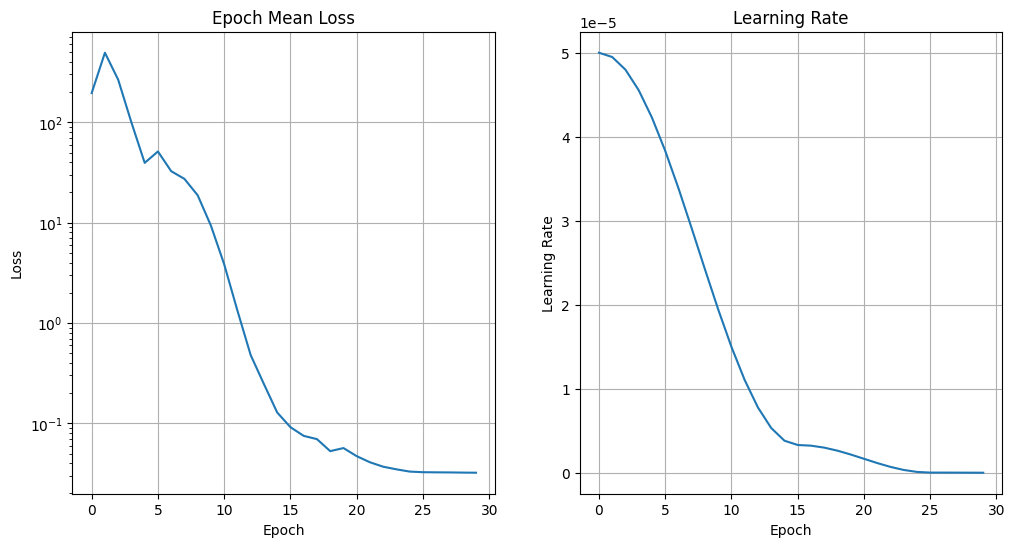

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Epoch Mean Loss plot
axis[0].set_title('Epoch Mean Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(epoch_loss_history)

# Learning Rate plot
axis[1].set_title('Learning Rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning Rate')
axis[1].grid()
axis[1].plot(lr_history)

## Тестирование нейросети

#### Подготовка Dataset и DataLoader для тестирования

In [15]:
test_dataset = SiameseDataset(path='siamese_data/test')

In [16]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=len(test_dataset))

#### Расчет метрик

In [17]:
losses = []

for i, (x_1, x_2, y) in enumerate(test_dataloader):
    if x_1
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        loss = criterion(out_1, out_2, y)
        losses.append(loss.item())

X = torch.cat((y, dist), 1)

print(f'Loss = {np.mean(losses)}')
print(f'Distance range between identical objects: [{X[X[:, 0] == 0, :][:, 1].min()}, {X[X[:, 0] == 0, :][:, 1].max()}]')
print(f'Distance range between different objects: [{X[X[:, 0] == 1, :][:, 1].min()}, {X[X[:, 0] == 1, :][:, 1].max()}]')

Loss = 103.6526107788086
Distance range between identical objects: [0.00015928654465824366, 208.43263244628906]
Distance range between different objects: [29.300222396850586, 1791.5555419921875]


## Отладка результатов

In [50]:
debug_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               shuffle=True,
                                               batch_size=1)

In [57]:
dist_max = 0.0
for i, (x_1, x_2, y) in enumerate(debug_dataloader):
    if (x_1[:, 0, :] == 0).sum() > 0 or (x_2[:, 0, :] == 0).sum() > 0:
        continue
    if y != 0.0:
        continue
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        
        dist = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim=True)
        if dist.item() > dist_max:
            dist_max = dist.item()
        loss = criterion(out_1, out_2, y)

        # if dist < 1.0:
            # continue

        # print('x_1:')
        # print(x_1)
        # print(x_1[0])
        # print('x_2:')
        # print(x_2)
        # print(f'Actual: {y.item()}')
        # print(f'out_1 = {out_1}')
        # print(f'out_2 = {out_2}')
        # print(f'd(out_1, out_2) = {dist.item()}')
        # print(f'loss = {loss.item()}')
        
        # _ = input()

In [58]:
dist_max

2.4000802040100098